In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import gc

from scipy import signal
import lightgbm as lgb
from sklearn.metrics import accuracy_score

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Using TensorFlow backend.


In [2]:
from sklearn.metrics import roc_auc_score

In [3]:
X_train = pd.read_csv('../input/X_train.csv')
y_train = pd.read_csv('../input/y_train.csv')
X_test  = pd.read_csv('../input/X_test.csv')

In [4]:
rotated_tr = pd.read_csv('./rotated_train.csv')
rotated_te = pd.read_csv('./rotated_test.csv')

In [5]:
rotated_tr.head()

,Unnamed: 0,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_X,euler_Y,euler_Z,rotated_acceleration_X,rotated_acceleration_Y,rotated_acceleration_Z
0,0,0_0,0,0,-0.758531,-0.634351,-0.10488,-0.10597,0.049000,0.007993,0.000349,-0.748570,2.103000,-9.753200,2.843273,-0.024668,1.396667,-3.051001,-0.494137,0.399795
1,1,0_1,0,1,-0.758532,-0.634342,-0.10490,-0.10600,-0.045981,0.001089,0.000993,-0.422014,1.924020,-9.651080,2.843201,-0.024662,1.396651,-2.960201,-0.525346,0.233054
2,2,0_2,0,2,-0.758528,-0.634348,-0.10492,-0.10597,-0.060919,-0.010782,-0.005251,-0.374697,1.824474,-9.373766,2.843222,-0.024728,1.396677,-2.867595,-0.789269,0.182175
3,3,0_3,0,3,-0.758516,-0.634357,-0.10495,-0.10597,-0.008044,-0.014070,-0.000219,-0.134236,1.606922,-9.590436,2.843183,-0.024769,1.396712,-2.883905,-0.552604,-0.075144
4,4,0_4,0,4,-0.758522,-0.634352,-0.10495,-0.10596,0.040927,-0.007411,0.010239,-0.246872,1.565515,-9.845605,2.843197,-0.024785,1.396698,-2.977078,-0.352939,-0.157436


In [6]:
targets = y_train['surface'].value_counts().index
print(targets)
print(y_train['surface'].value_counts())

Index(['concrete', 'soft_pvc', 'wood', 'tiled', 'fine_concrete',
       'hard_tiles_large_space', 'soft_tiles', 'carpet', 'hard_tiles'],
      dtype='object')
concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64


In [7]:
target_to_id = {}
id_to_target = {}

for target in targets:
    if target not in target_to_id:
        new_id = len(target_to_id)
        target_to_id[target] = new_id
        id_to_target[new_id] = target

In [8]:
y_id = []
for i in range(len(y_train)):
    y_id.append(target_to_id[y_train['surface'].values[i]])
y_id = np.asarray(y_id)

In [9]:
class_num = len(targets)

In [10]:
y_id_one = np.zeros((len(y_id), class_num))
for i in range(len(y_id)):
    y_id_one[i, y_id[i]] = 1 

In [11]:
def norm_quat(df):
    norm = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2 + df['orientation_W']**2)**0.5
    df['orientation_X'] /= norm
    df['orientation_Y'] /= norm
    df['orientation_Z'] /= norm
    df['orientation_W'] /= norm
    return df

In [12]:
import math

def quaternion_to_euler(x, y, z, w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [13]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [14]:
X_train = norm_quat(X_train)
X_test = norm_quat(X_test)

In [15]:
def fe_step1 (df):
    """Quaternions to Euler Angles"""
    
    x = df['orientation_X'].values
    y = df['orientation_Y'].values
    z = df['orientation_Z'].values
    w = df['orientation_W'].values
    nx, ny, nz = np.zeros(len(x)), np.zeros(len(y)), np.zeros(len(z)),
    for i in tqdm(range(len(x))):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx[i] = xx
        ny[i] = yy
        nz[i] = zz
    
    df['euler_X'] = nx
    df['euler_Y'] = ny
    df['euler_Z'] = nz
    return df

In [16]:
X_train = fe_step1(X_train)
X_test = fe_step1(X_test)

100%|██████████| 488448/488448 [00:01<00:00, 302278.89it/s]


In [17]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_X,euler_Y,euler_Z
0,0_0,0,0,-0.758531,-0.634351,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.758532,-0.634342,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.758528,-0.634348,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.758516,-0.634357,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.758522,-0.634352,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,2.843197,-0.024785,1.396698


In [18]:
for data in [X_train, X_test]:
    data['obs_roll'] = np.arctan(data['linear_acceleration_Y']/data['linear_acceleration_Z'])
    data['obs_pitch'] = -np.arctan(data['linear_acceleration_X']/(data['linear_acceleration_Y']**2+data['linear_acceleration_Z']**2)**0.5)

In [44]:
cols = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']

In [45]:
for col in cols:
    X_train['cos_'+col] = np.cos(X_train[col])
    X_test['cos_'+col] = np.cos(X_test[col])

In [16]:
def highpass_filter(df):
    n_samples = 128
    sample_duration = 0.01
    sample_rate = n_samples * (1 / sample_duration)

    nyquist = 0.5 * sample_rate
    norm_low_cutoff = 500 / nyquist

    sos = signal.butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, df)
    
    return filtered_sig

In [17]:
def lowpass_filter(data, r=0.3):
    f_data = np.zeros_like(data)
    f_data[0] = data[0]
    for i in range(1, len(data)):
        if i % 128 == 0:
            f_data[i] = data[i]
        else:
            f_data[i] = r * data[i] + (1-r) * f_data[i-1]
    return f_data

In [18]:
for data in [X_train, X_test]:
    data['linear_acceleration_X'] = lowpass_filter(data['linear_acceleration_X'])
    data['linear_acceleration_Y'] = lowpass_filter(data['linear_acceleration_Y'])
    data['linear_acceleration_Z'] = lowpass_filter(data['linear_acceleration_Z'])
    #data['angular_velocity_X'] = highpass_filter(data['angular_velocity_X'])
    #data['angular_velocity_Y'] = highpass_filter(data['angular_velocity_Y'])
    #data['angular_velocity_Z'] = highpass_filter(data['angular_velocity_Z'])

In [19]:
def lagged_feature(df, lag_list):
    
    cols = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']
    
    for col in cols:
        for i in lag_list:
            df[col+'-'+str(i)] = 0
            df.loc[i: , col+'-'+str(i)] = df.loc[:len(df)-(i+1), col].values
            df[col+'-'+col+'-'+str(i)] = df[col] - df[col+'-'+str(i)]
            
            df = df.drop([col+'-'+str(i)], axis=1)
    return df

In [20]:
def num_integration(df):
    
    cols = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']
    
    for col in cols:
        i = 1
        df[col+'-'+str(i)] = 0
        df.loc[i: , col+'-'+str(i)] = df.loc[:len(df)-(i+1), col].values
        df['tmp'+col] = 0.5 * (df[col] + df[col+'-'+str(i)])
        df['num_int_'+col] = 0
        for j in tqdm(range(0, len(df), 128)):
            df.loc[j:j+128, 'num_int_'+col] = np.cumsum(df.loc[j:j+128, 'tmp'+col])

        df = df.drop([col+'-'+str(i)], axis=1)
        df = df.drop(['tmp'+col], axis=1)
    return df

In [46]:
X_train['linear_acceleration_Z'] = X_train['linear_acceleration_Z'] + 9.80665
X_test['linear_acceleration_Z'] = X_test['linear_acceleration_Z'] + 9.80665

In [42]:
lag_list = [1, 2]
X_train = lagged_feature(X_train, lag_list)
X_test = lagged_feature(X_test, lag_list)

In [43]:
X_train = num_integration(X_train)
X_test = num_integration(X_test)

100%|██████████| 3816/3816 [00:04<00:00, 766.37it/s]


In [47]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_X,euler_Y,euler_Z,obs_roll,obs_pitch,cos_angular_velocity_X,cos_angular_velocity_Y,cos_angular_velocity_Z
0,0_0,0,0,-0.758531,-0.634351,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,0.05345,2.843273,-0.024668,1.396667,-0.212370,0.074887,0.994211,0.999846,1.000000
1,0_1,0,1,-0.758532,-0.634342,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,0.39385,2.843201,-0.024662,1.396651,-0.158692,-0.035647,0.997699,0.999552,0.999994
2,0_2,0,2,-0.758528,-0.634348,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,1.07995,2.843222,-0.024728,1.396677,-0.180467,0.029785,0.999974,0.999581,0.999982
3,0_3,0,3,-0.758516,-0.634357,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-0.28935,2.843183,-0.024769,1.396712,-0.108457,-0.042005,0.999915,0.999811,0.999960
4,0_4,0,4,-0.758522,-0.634352,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-0.63435,2.843197,-0.024785,1.396698,-0.139768,0.048303,0.999987,0.999971,0.999986


In [ ]:
i=0
plt.plot(X_train.iloc[128*i:128*(i+1), :]['linear_acceleration_Y'])

for i in tqdm(range(0, len(X_train), 128)):
    X_train = X_train.drop(index=[i+j for j in range(1)])

In [23]:
def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

In [18]:
train = X_train.loc[:, 'orientation_X':'orientation_W']
test = X_test.loc[:, 'orientation_X':'orientation_W']

train.columns = ['X','Y','Z','W']
test.columns = ['X','Y','Z','W']

for i in range(4):
    for j in range(i+1, 4):
        train[train.columns[i]+'-'+train.columns[j]] = train.iloc[:, i] - train.iloc[:, j]
        test[test.columns[i]+'-'+test.columns[j]] = test.iloc[:, i] - test.iloc[:, j]
        
train = pd.concat([train, X_train.loc[:, 'euler_X':'obs_pitch']], axis=1)
test = pd.concat([test, X_test.loc[:, 'euler_X':'obs_pitch']], axis=1)

In [19]:
for data in [train, test]:
    data['euler_X-Y'] = data['euler_X']-data['euler_Y']
    data['euler_X-Z'] = data['euler_X']-data['euler_Z']
    data['euler_Y-Z'] = data['euler_Y']-data['euler_Z']
    
train = pd.concat([X_train['series_id'], train], axis=1)
test = pd.concat([X_test['series_id'], test], axis=1)

In [20]:
train.head()

,series_id,X,Y,Z,W,X-Y,X-Z,X-W,Y-Z,Y-W,Z-W,euler_X,euler_Y,euler_Z,obs_roll,obs_pitch,euler_X-Y,euler_X-Z,euler_Y-Z
0,0,-0.758531,-0.634351,-0.10488,-0.10597,-0.124180,-0.653651,-0.652561,-0.529471,-0.528381,0.00109,2.843273,-0.024668,1.396667,-0.212370,0.074887,2.867941,1.446606,-1.421335
1,0,-0.758532,-0.634342,-0.10490,-0.10600,-0.124190,-0.653632,-0.652532,-0.529441,-0.528341,0.00110,2.843201,-0.024662,1.396651,-0.158692,-0.035647,2.867863,1.446549,-1.421314
2,0,-0.758528,-0.634348,-0.10492,-0.10597,-0.124180,-0.653608,-0.652558,-0.529429,-0.528379,0.00105,2.843222,-0.024728,1.396677,-0.180467,0.029785,2.867950,1.446546,-1.421405
3,0,-0.758516,-0.634357,-0.10495,-0.10597,-0.124159,-0.653567,-0.652547,-0.529408,-0.528388,0.00102,2.843183,-0.024769,1.396712,-0.108457,-0.042005,2.867953,1.446471,-1.421481
4,0,-0.758522,-0.634352,-0.10495,-0.10596,-0.124170,-0.653572,-0.652562,-0.529401,-0.528391,0.00101,2.843197,-0.024785,1.396698,-0.139768,0.048303,2.867981,1.446498,-1.421483


In [ ]:
X_train.head()

In [ ]:
def rotation_matrix(q0, q1, q2, q3):
    r00 = q0**2 - q1**2 - q2**2 + q3**2
    r01 = 2 * (q0*q3 + q1*q2)
    r02 = 2 * (q1*q3 - q0*q2)
    r10 = 2 * (q1*q2 - q0*q3)
    r11 = q0**2 - q1**2 + q2**2 - q3**2
    r12 = 2 * (q2*q3 + q0*q1)
    r20 = 2 * (q0*q2 + q1*q3)
    r21 = 2 * (-q0*q1 + q2*q3)
    r22 = q0**2 - q1**2 - q2**2 + q3**2
    R = np.array([[r00, r01, r02],[r10, r11, r12],[r20, r21, r22]])
    return R

In [ ]:
def rotated_acceleration(df):
    
    df['rotated_acceleration_X'] = 0
    df['rotated_acceleration_Y'] = 0
    df['rotated_acceleration_Z'] = 0
    #df['rotated_angvel_X'] = 0
    #df['rotated_angvel_Y'] = 0
    #df['rotated_angvel_Z'] = 0
    
    q0_all = df['orientation_X'].values
    q1_all = df['orientation_Y'].values
    q2_all = df['orientation_Z'].values
    q3_all = df['orientation_W'].values
    la_X = df['linear_acceleration_X'].values
    la_Y = df['linear_acceleration_Y'].values
    la_Z = df['linear_acceleration_Z'].values
    #av_X = df['angular_velocity_X'].values
    #av_Y = df['angular_velocity_Y'].values
    #av_Z = df['angular_velocity_Z'].values
    
    for i in tqdm(range(len(df))):
        q0 = q0_all[i]
        q1 = q1_all[i]
        q2 = q2_all[i]
        q3 = q3_all[i]
        
        R = rotation_matrix(q0, q1, q2, q3)
        la = np.array([la_X[i], la_Y[i], la_Z[i]])
        #av = np.array([av_X[i], av_Y[i], av_Z[i]])
        rotated_la = np.dot(R.T, la)
        #rotated_av = np.dot(R.T, av)
        
        df.loc[i, 'rotated_acceleration_X'] = rotated_la[0]
        df.loc[i, 'rotated_acceleration_Y'] = rotated_la[1]
        df.loc[i, 'rotated_acceleration_Z'] = rotated_la[2]
        #df.loc[i, 'rotated_angvel_X'] = rotated_av[0]
        #df.loc[i, 'rotated_angvel_Y'] = rotated_av[1]
        #df.loc[i, 'rotated_angvel_Z'] = rotated_av[2]
    
    return df

In [ ]:
X_train = rotated_acceleration(X_train)

In [ ]:
X_test = rotated_acceleration(X_test)

In [ ]:
X_train['rotated_acceleration_Y'] = X_train['rotated_acceleration_Y'] - 9.80665
X_test['rotated_acceleration_Y'] = X_test['rotated_acceleration_Y'] - 9.80665

from multiprocessing import Pool

def process_subtrain(arg_tuple):
    start, end, idx = arg_tuple
    X_tr = X_train.iloc[start:end, :]
    X_tr = rotated_acceleration(X_tr)
    return idx, X_tr

all_chunks = []

num_cores = 8 
total_size = len(X_train)
chunk_size = total_size/num_cores

for i in range(8):
    start_idx = int(i * chunk_size)
    end_idx = int(start_idx + chunk_size)
    chunk = (start_idx, end_idx, i)
    all_chunks.append(chunk)

pool = Pool()
results = pool.map(process_subtrain, all_chunks)    
results = sorted(results, key=lambda tup: tup[0])


X = np.concatenate([item[1] for item in results], axis=0)

train = pd.concat([train, X_train.loc[:, 'rotated_acceleration_X':'rotated_acceleration_Z']], axis=1)
test = pd.concat([test, X_test.loc[:, 'rotated_acceleration_X':'rotated_acceleration_Z']], axis=1)

In [21]:
def feat_eng(df):
    data = pd.DataFrame()
    #df['total_rotated_acce'] = (df['rotated_acceleration_X']**2 + df['rotated_acceleration_Y']**2 + df['rotated_acceleration_Z']**2)**0.5
    df['ang_XY'] = np.arctan2(df['X'], df['Y'])
    df['ang_ZW'] = np.arctan2(df['Z'], df['W'])
    
    df_columns = df.columns[1:]
    for col in tqdm(df_columns):
        data[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        #data[col + '_median'] = df.groupby(['series_id'])[col].median()
        data[col + '_max'] = df.groupby(['series_id'])[col].max()
        data[col + '_min'] = df.groupby(['series_id'])[col].min()
        data[col + '_std'] = df.groupby(['series_id'])[col].std()
        data[col + '_range'] = data[col + '_max'] - data[col + '_min']
        data[col + '_maxtoMin'] = data[col + '_max'] / data[col + '_min']
        
        data[col + '_mean_abs_chg'] = df.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        data[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        data[col + '_abs_max'] = df.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        data[col + '_abs_min'] = df.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        data[col + '_abs_avg'] = (data[col + '_abs_min'] + data[col + '_abs_max'])/2
        
        
    #data['corr_linZangX'] = np.correlate(np.abs(tmp_df[:, 0]), np.abs(tmp_df[:, 1]))
    return data

In [ ]:
train = pd.concat([train, rotated_tr.loc[:, 'rotated_acceleration_X':'rotated_acceleration_Z']], axis=1)
test = pd.concat([test, rotated_te.loc[:, 'rotated_acceleration_X':'rotated_acceleration_Z']], axis=1)

In [24]:
train = feat_eng(train)
test = feat_eng(test)

100%|██████████| 20/20 [00:43<00:00,  2.16s/it]


In [25]:
data_col = train.columns

In [26]:
train.head()

,X_mean,X_max,X_min,X_std,X_range,X_maxtoMin,X_mean_abs_chg,X_mean_change_of_abs_change,X_abs_max,X_abs_min,X_abs_avg,Y_mean,Y_max,Y_min,Y_std,Y_range,Y_maxtoMin,Y_mean_abs_chg,Y_mean_change_of_abs_change,Y_abs_max,Y_abs_min,Y_abs_avg,Z_mean,Z_max,Z_min,Z_std,Z_range,Z_maxtoMin,Z_mean_abs_chg,Z_mean_change_of_abs_change,Z_abs_max,Z_abs_min,Z_abs_avg,W_mean,W_max,W_min,W_std,W_range,W_maxtoMin,W_mean_abs_chg,W_mean_change_of_abs_change,W_abs_max,W_abs_min,W_abs_avg,X-Y_mean,X-Y_max,X-Y_min,X-Y_std,X-Y_range,X-Y_maxtoMin,X-Y_mean_abs_chg,X-Y_mean_change_of_abs_change,X-Y_abs_max,X-Y_abs_min,X-Y_abs_avg,X-Z_mean,X-Z_max,X-Z_min,X-Z_std,X-Z_range,X-Z_maxtoMin,X-Z_mean_abs_chg,X-Z_mean_change_of_abs_change,X-Z_abs_max,X-Z_abs_min,X-Z_abs_avg,X-W_mean,X-W_max,X-W_min,X-W_std,X-W_range,X-W_maxtoMin,X-W_mean_abs_chg,X-W_mean_change_of_abs_change,X-W_abs_max,X-W_abs_min,X-W_abs_avg,Y-Z_mean,Y-Z_max,Y-Z_min,Y-Z_std,Y-Z_range,Y-Z_maxtoMin,Y-Z_mean_abs_chg,Y-Z_mean_change_of_abs_change,Y-Z_abs_max,Y-Z_abs_min,Y-Z_abs_avg,Y-W_mean,Y-W_max,Y-W_min,Y-W_std,Y-W_range,Y-W_maxtoMin,Y-W_mean_abs_chg,Y-W_mean_change_of_abs_change,Y-W_abs_max,Y-W_abs_min,Y-W_abs_avg,Z-W_mean,...,euler_X_abs_avg,euler_Y_mean,euler_Y_max,euler_Y_min,euler_Y_std,euler_Y_range,euler_Y_maxtoMin,euler_Y_mean_abs_chg,euler_Y_mean_change_of_abs_change,euler_Y_abs_max,euler_Y_abs_min,euler_Y_abs_avg,euler_Z_mean,euler_Z_max,euler_Z_min,euler_Z_std,euler_Z_range,euler_Z_maxtoMin,euler_Z_mean_abs_chg,euler_Z_mean_change_of_abs_change,euler_Z_abs_max,euler_Z_abs_min,euler_Z_abs_avg,obs_roll_mean,obs_roll_max,obs_roll_min,obs_roll_std,obs_roll_range,obs_roll_maxtoMin,obs_roll_mean_abs_chg,obs_roll_mean_change_of_abs_change,obs_roll_abs_max,obs_roll_abs_min,obs_roll_abs_avg,obs_pitch_mean,obs_pitch_max,obs_pitch_min,obs_pitch_std,obs_pitch_range,obs_pitch_maxtoMin,obs_pitch_mean_abs_chg,obs_pitch_mean_change_of_abs_change,obs_pitch_abs_max,obs_pitch_abs_min,obs_pitch_abs_avg,euler_X-Y_mean,euler_X-Y_max,euler_X-Y_min,euler_X-Y_std,euler_X-Y_range,euler_X-Y_maxtoMin,euler_X-Y_mean_abs_chg,euler_X-Y_mean_change_of_abs_change,euler_X-Y_abs_max,euler_X-Y_abs_min,euler_X-Y_abs_avg,euler_X-Z_mean,euler_X-Z_max,euler_X-Z_min,euler_X-Z_std,euler_X-Z_range,euler_X-Z_maxtoMin,euler_X-Z_mean_abs_chg,euler_X-Z_mean_change_of_abs_change,euler_X-Z_abs_max,euler_X-Z_abs_min,euler_X-Z_abs_avg,euler_Y-Z_mean,euler_Y-Z_max,euler_Y-Z_min,euler_Y-Z_std,euler_Y-Z_range,euler_Y-Z_maxtoMin,euler_Y-Z_mean_abs_chg,euler_Y-Z_mean_change_of_abs_change,euler_Y-Z_abs_max,euler_Y-Z_abs_min,euler_Y-Z_abs_avg,ang_XY_mean,ang_XY_max,ang_XY_min,ang_XY_std,ang_XY_range,ang_XY_maxtoMin,ang_XY_mean_abs_chg,ang_XY_mean_change_of_abs_change,ang_XY_abs_max,ang_XY_abs_min,ang_XY_abs_avg,ang_ZW_mean,ang_ZW_max,ang_ZW_min,ang_ZW_std,ang_ZW_range,ang_ZW_maxtoMin,ang_ZW_mean_abs_chg,ang_ZW_mean_change_of_abs_change,ang_ZW_abs_max,ang_ZW_abs_min,ang_ZW_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.758219,-0.759527,0.000363,0.001308,0.998278,0.000016,2.093952e-07,0.759527,0.758219,0.758873,-0.634007,-0.633057,-0.634560,0.000471,0.001502,0.997632,0.000018,2.393871e-08,0.634560,0.633057,0.633808,-0.105474,-0.104610,-0.106140,0.000432,0.001530,0.985582,0.000051,8.154597e-08,0.106140,0.104610,0.105375,-0.106470,-0.105590,-0.107050,0.000389,0.001460,0.986358,0.000042,4.784270e-07,0.107050,0.105590,0.106320,-0.124658,-0.123700,-0.126469,0.000827,0.002770,0.978098,0.000031,2.333339e-07,0.126469,0.123700,0.125084,-0.653191,-0.652286,-0.654917,0.000619,0.002631,0.995983,0.000060,3.037773e-07,0.654917,0.652286,0.653602,-0.652196,-0.651518,-0.652918,0.000350,0.001400,0.997856,0.000046,7.006584e-07,0.652918,0.651518,0.652218,-0.528533,-0.527307,-0.529639,0.000648,0.002332,0.995597,0.000056,-9.038861e-08,0.529639,0.527307,0.528473,-0.527538,-0.526140,-

In [ ]:
for data in [train, test]:
    data.fillna(0,inplace=True)
    data.replace(-np.inf,0,inplace=True)
    data.replace(np.inf,0,inplace=True)

In [27]:
y_gr = y_train['group_id']

In [28]:
N_SPLITS=4

splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(train, y_gr))

clf = []
val_acc = []
val_pred = []
val_y = []

lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'multi_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'multiclass',
               'num_class': 73,
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }

for train_idx, val_idx in splits:
    X_tr, y_tr = np.asarray(train)[train_idx, :], y_gr[train_idx]
    X_val, y_val = np.asarray(train)[val_idx, :], y_gr[val_idx]
    
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)
    val_pred.append(pred_lgb)
    val_y.append(y_val)
    
    val_acc.append(accuracy_score(y_val, np.argmax(pred_lgb, axis=1)))

#pred_lgb = pd.DataFrame(pred_lgb, index=np.where(np.mean(adv_val, axis=0)>0.3))
#val_pred = pd.concat([val_pred, pred_lgb], axis=0)

    clf.append(model_lgb)

[1]	valid_0's multi_logloss: 2.66058
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 2.37979
[3]	valid_0's multi_logloss: 2.18302
[4]	valid_0's multi_logloss: 2.03303
[5]	valid_0's multi_logloss: 1.91058
[6]	valid_0's multi_logloss: 1.80469
[7]	valid_0's multi_logloss: 1.71306
[8]	valid_0's multi_logloss: 1.63369
[9]	valid_0's multi_logloss: 1.56194
[10]	valid_0's multi_logloss: 1.4951
[11]	valid_0's multi_logloss: 1.43822
[12]	valid_0's multi_logloss: 1.38867
[13]	valid_0's multi_logloss: 1.34272
[14]	valid_0's multi_logloss: 1.29924
[15]	valid_0's multi_logloss: 1.2588
[16]	valid_0's multi_logloss: 1.22316
[17]	valid_0's multi_logloss: 1.19032
[18]	valid_0's multi_logloss: 1.15996
[19]	valid_0's multi_logloss: 1.13137
[20]	valid_0's multi_logloss: 1.10438
[21]	valid_0's multi_logloss: 1.07998
[22]	valid_0's multi_logloss: 1.05675
[23]	valid_0's multi_logloss: 1.03487
[24]	valid_0's multi_logloss: 1.01474
[25]	valid_0's multi_logloss: 0.99584

[2]	valid_0's multi_logloss: 2.35198
[3]	valid_0's multi_logloss: 2.15763
[4]	valid_0's multi_logloss: 2.00685
[5]	valid_0's multi_logloss: 1.88368
[6]	valid_0's multi_logloss: 1.77881
[7]	valid_0's multi_logloss: 1.68949
[8]	valid_0's multi_logloss: 1.61146
[9]	valid_0's multi_logloss: 1.54498
[10]	valid_0's multi_logloss: 1.48329
[11]	valid_0's multi_logloss: 1.42906
[12]	valid_0's multi_logloss: 1.37913
[13]	valid_0's multi_logloss: 1.33232
[14]	valid_0's multi_logloss: 1.29061
[15]	valid_0's multi_logloss: 1.25339
[16]	valid_0's multi_logloss: 1.21692
[17]	valid_0's multi_logloss: 1.18596
[18]	valid_0's multi_logloss: 1.15233
[19]	valid_0's multi_logloss: 1.12473
[20]	valid_0's multi_logloss: 1.09993
[21]	valid_0's multi_logloss: 1.07651
[22]	valid_0's multi_logloss: 1.05336
[23]	valid_0's multi_logloss: 1.03188
[24]	valid_0's multi_logloss: 1.01173
[25]	valid_0's multi_logloss: 0.994487
[26]	valid_0's multi_logloss: 0.977742
[27]	valid_0's multi_logloss: 0.96053
[28]	valid_0's mul

In [29]:
val_acc

[0.8133874239350912, 0.76875, 0.8055555555555556, 0.8017241379310345]

In [30]:
feature_imp = np.zeros(train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp/4, index=data_col).sort_values(by=0, ascending=False)

,0
X-Z_min,3724.134437
obs_pitch_mean_abs_chg,2683.091345
ang_ZW_mean,2628.317776
X-W_min,2545.977695
Y-W_min,2398.698954
euler_X_mean,2302.224772
ang_XY_mean,2275.321806
obs_roll_mean_abs_chg,2252.691929
ang_ZW_min,2200.822026
Z_min,2111.208492


In [ ]:
X_train_reserve = X_train.copy()
X_test_reserve = X_test.copy()

In [ ]:
X_train_reserve.to_csv('./rotated_train.csv')
X_test_reserve.to_csv('./rotated_test.csv')

In [48]:
def feat_eng(df):
    data = pd.DataFrame()

    df['total_acce'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z']**2)**0.5
    #df['total_rotated'] = (df['rotated_acceleration_X']**2 + df['rotated_acceleration_Y']**2 + df['rotated_acceleration_Z']**2)**0.5
    #df['total_ang_cos'] = (df['cos_angular_velocity_X']**2 + df['cos_angular_velocity_Y']**2 + df['cos_angular_velocity_Z']**2)**0.5
    
    df = df.drop(columns=['euler_X'], axis=0)
    df = df.drop(columns=['euler_Y'], axis=0)
    df = df.drop(columns=['euler_Z'], axis=0)
    #df['total_angu'] = (df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z']**2)**0.5
    
    #df['total_eule'] = (df['euler_X']**2 + df['euler_Y']**2 + df['euler_Z']**2)**0.5
    #df['total_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2)**0.5
    #df['total_acc/vel'] = df['total_acce']/df['total_angu']
    
    df_columns = df.columns[7:]
    for col in tqdm(df_columns):
        data[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        data[col + '_median'] = df.groupby(['series_id'])[col].median()
        data[col + '_max'] = df.groupby(['series_id'])[col].max()
        data[col + '_min'] = df.groupby(['series_id'])[col].min()
        data[col + '_std'] = df.groupby(['series_id'])[col].std()
        data[col + '_range'] = data[col + '_max'] - data[col + '_min']
        data[col + '_maxtoMin'] = data[col + '_max'] / data[col + '_min']
        data[col + '_mean_abs_chg'] = df.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        data[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        data[col + '_abs_max'] = df.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        data[col + '_abs_min'] = df.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        data[col + '_abs_avg'] = (data[col + '_abs_min'] + data[col + '_abs_max'])/2
        
        
    #data['corr_linZangX'] = np.correlate(np.abs(tmp_df[:, 0]), np.abs(tmp_df[:, 1]))
    return data

In [49]:
X_train = feat_eng(X_train)
X_test = feat_eng(X_test)

100%|██████████| 12/12 [00:26<00:00,  2.19s/it]


In [51]:
y = np.concatenate((np.zeros(len(X_train)), np.ones(len(X_test))), axis=0)
X = np.concatenate((X_train, X_test), axis=0)

In [50]:
N_SPLITS=4

In [52]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))

clf_2 = []
val_roc = []
val_pred = pd.DataFrame()

lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'binary_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary',
               #'num_class': class_num,
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in splits:
    X_tr, y_tr = X[train_idx, :], y[train_idx]
    X_val, y_val = X[val_idx, :], y[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)
    
    val_roc.append(roc_auc_score(y_val, (pred_lgb>0.5).astype(int)))
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=0)
    
    clf_2.append(model_lgb)

[1]	valid_0's binary_logloss: 0.689428
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.686548
[3]	valid_0's binary_logloss: 0.684913
[4]	valid_0's binary_logloss: 0.681737
[5]	valid_0's binary_logloss: 0.679838
[6]	valid_0's binary_logloss: 0.678564
[7]	valid_0's binary_logloss: 0.677262
[8]	valid_0's binary_logloss: 0.676165
[9]	valid_0's binary_logloss: 0.675096
[10]	valid_0's binary_logloss: 0.674168
[11]	valid_0's binary_logloss: 0.674003
[12]	valid_0's binary_logloss: 0.673677
[13]	valid_0's binary_logloss: 0.672803
[14]	valid_0's binary_logloss: 0.671846
[15]	valid_0's binary_logloss: 0.671473
[16]	valid_0's binary_logloss: 0.67024
[17]	valid_0's binary_logloss: 0.669595
[18]	valid_0's binary_logloss: 0.669107
[19]	valid_0's binary_logloss: 0.669382
[20]	valid_0's binary_logloss: 0.669053
[21]	valid_0's binary_logloss: 0.66865
[22]	valid_0's binary_logloss: 0.668183
[23]	valid_0's binary_logloss: 0.66765
[24]	valid_0's binary_logloss:

[5]	valid_0's binary_logloss: 0.679583
[6]	valid_0's binary_logloss: 0.678587
[7]	valid_0's binary_logloss: 0.676537
[8]	valid_0's binary_logloss: 0.675538
[9]	valid_0's binary_logloss: 0.674967
[10]	valid_0's binary_logloss: 0.674866
[11]	valid_0's binary_logloss: 0.674226
[12]	valid_0's binary_logloss: 0.673527
[13]	valid_0's binary_logloss: 0.673034
[14]	valid_0's binary_logloss: 0.672083
[15]	valid_0's binary_logloss: 0.671173
[16]	valid_0's binary_logloss: 0.671165
[17]	valid_0's binary_logloss: 0.670384
[18]	valid_0's binary_logloss: 0.670816
[19]	valid_0's binary_logloss: 0.670702
[20]	valid_0's binary_logloss: 0.670984
[21]	valid_0's binary_logloss: 0.670715
[22]	valid_0's binary_logloss: 0.670209
[23]	valid_0's binary_logloss: 0.669802
[24]	valid_0's binary_logloss: 0.669256
[25]	valid_0's binary_logloss: 0.668342
[26]	valid_0's binary_logloss: 0.667931
[27]	valid_0's binary_logloss: 0.667864
[28]	valid_0's binary_logloss: 0.667445
[29]	valid_0's binary_logloss: 0.667474
[30]	

In [53]:
val_roc

[0.5825837419513795, 0.5904250287627507, 0.562419621936825, 0.5860100329439952]

In [54]:
feature_imp = np.zeros(X.shape[1])
for model in clf_2:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp, index=X_train.columns).sort_values(by=0, ascending=False)

,0
linear_acceleration_Y_mean,1048.629451
linear_acceleration_Z_mean,907.008640
angular_velocity_Y_min,521.649536
angular_velocity_Y_maxtoMin,484.925865
linear_acceleration_X_mean_abs_chg,453.225640
angular_velocity_X_maxtoMin,405.448290
obs_roll_mean,395.901482
angular_velocity_X_mean_abs_chg,356.845628
total_acce_median,348.582111
angular_velocity_Y_median,342.605014


In [55]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X_train, y_id))

clf_3 = []
val_acc = []
val_pred = pd.DataFrame()

lgb_params = {
               'feature_fraction': 0.9,
               'metric': 'multi_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'multiclass',
               'num_class': class_num,
               'num_leaves': 2**5,
               'verbose':0, 
               'seed':123
              }

for train_idx, val_idx in splits:
    X_tr, y_tr = X_train.iloc[train_idx, :], y_id[train_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_id[val_idx]
    
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)

    val_acc.append(accuracy_score(y_val, np.argmax(pred_lgb, axis=1)))

#pred_lgb = pd.DataFrame(pred_lgb, index=np.where(np.mean(adv_val, axis=0)>0.3))
#val_pred = pd.concat([val_pred, pred_lgb], axis=0)

clf_3.append(model_lgb)

[1]	valid_0's multi_logloss: 1.89079
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.80232
[3]	valid_0's multi_logloss: 1.73301
[4]	valid_0's multi_logloss: 1.67137
[5]	valid_0's multi_logloss: 1.62297
[6]	valid_0's multi_logloss: 1.58009
[7]	valid_0's multi_logloss: 1.5395
[8]	valid_0's multi_logloss: 1.50723
[9]	valid_0's multi_logloss: 1.47807
[10]	valid_0's multi_logloss: 1.4505
[11]	valid_0's multi_logloss: 1.42809
[12]	valid_0's multi_logloss: 1.40447
[13]	valid_0's multi_logloss: 1.38649
[14]	valid_0's multi_logloss: 1.36871
[15]	valid_0's multi_logloss: 1.35213
[16]	valid_0's multi_logloss: 1.33731
[17]	valid_0's multi_logloss: 1.32239
[18]	valid_0's multi_logloss: 1.30975
[19]	valid_0's multi_logloss: 1.29856
[20]	valid_0's multi_logloss: 1.28907
[21]	valid_0's multi_logloss: 1.28046
[22]	valid_0's multi_logloss: 1.27234
[23]	valid_0's multi_logloss: 1.26396
[24]	valid_0's multi_logloss: 1.25684
[25]	valid_0's multi_logloss: 1.25097

[55]	valid_0's multi_logloss: 1.20158
[56]	valid_0's multi_logloss: 1.20126
[57]	valid_0's multi_logloss: 1.20276
[58]	valid_0's multi_logloss: 1.20373
[59]	valid_0's multi_logloss: 1.20491
[60]	valid_0's multi_logloss: 1.20682
[61]	valid_0's multi_logloss: 1.20948
[62]	valid_0's multi_logloss: 1.20947
[63]	valid_0's multi_logloss: 1.21072
[64]	valid_0's multi_logloss: 1.21168
[65]	valid_0's multi_logloss: 1.21383
[66]	valid_0's multi_logloss: 1.21552
[67]	valid_0's multi_logloss: 1.21803
[68]	valid_0's multi_logloss: 1.21891
[69]	valid_0's multi_logloss: 1.21993
[70]	valid_0's multi_logloss: 1.22226
[71]	valid_0's multi_logloss: 1.22349
[72]	valid_0's multi_logloss: 1.22647
[73]	valid_0's multi_logloss: 1.22774
[74]	valid_0's multi_logloss: 1.23091
[75]	valid_0's multi_logloss: 1.23407
[76]	valid_0's multi_logloss: 1.23501
[77]	valid_0's multi_logloss: 1.2371
[78]	valid_0's multi_logloss: 1.23868
[79]	valid_0's multi_logloss: 1.24149
[80]	valid_0's multi_logloss: 1.24397
Early stoppin

In [56]:
val_acc

[0.5805439330543933,
 0.5739769150052466,
 0.5766806722689075,
 0.6048472075869337]

In [57]:
np.mean(val_acc)

0.5840121819788703

In [ ]:
val_acc

In [ ]:
np.mean(val_acc)

In [58]:
feature_imp = np.zeros(X_train.shape[1])
for model in clf_3:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp, index=X_train.columns).sort_values(by=0, ascending=False)

,0
linear_acceleration_X_mean_abs_chg,2958.376957
total_acce_mean_abs_chg,2482.627490
linear_acceleration_Y_mean_abs_chg,2470.310007
angular_velocity_Y_mean_abs_chg,2180.690695
angular_velocity_Z_min,1852.618465
total_acce_mean,1386.445559
angular_velocity_Y_maxtoMin,1202.925573
obs_pitch_mean_abs_chg,1016.131618
obs_roll_mean_abs_chg,1005.620599
linear_acceleration_Y_std,962.328289


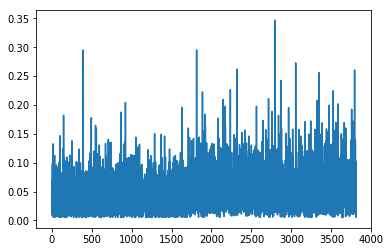

In [50]:
plt.plot(X_train['angular_velocity_Y-angular_velocity_Y-1_mean_abs_chg'])

In [33]:
test_pred = []
for model in clf:
    pred_test = model.predict(test)
    test_pred.append(pred_test)

In [34]:
test_pred = (test_pred[0]+test_pred[1]+test_pred[2]+test_pred[3])/4

In [35]:
test_pr = pd.concat([pd.Series(np.argmax(test_pred, axis=1)), pd.Series(np.max(test_pred, axis=1))], axis=1)
test_pr.columns = ['group_id', 'prob']

In [36]:
test_pr

,group_id,prob
0,33,0.938241
1,7,0.486229
2,55,0.944357
3,52,0.344079
4,15,0.981275
5,62,0.991397
6,61,0.618043
7,61,0.483613
8,65,0.878345
9,65,0.974462


In [37]:
gr_sr = pd.DataFrame()
for i in range(73):
    gr = pd.DataFrame({'group_id':[i], 'surface':[y_train[y_train['group_id']==i]['surface'].iloc[0]]})
    gr_sr = pd.concat([gr_sr, gr], axis=0)

In [38]:
test_pr = test_pr.merge(gr_sr, how='left', on='group_id', sort=False)

In [68]:
test_gr_idx = test_pr[test_pr['prob']<=0.7].index

In [40]:
X_test.loc[test_gr_idx, :].head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_X,euler_Y,euler_Z,obs_roll,obs_pitch
1,0_1,0,1,-0.025683,-0.988624,-0.148161,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,2.844435,-0.014411,3.091804,-0.461338,0.078914
3,0_3,0,3,-0.025566,-0.988625,-0.148171,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,2.844420,-0.014712,3.092086,-0.150821,-0.057423
6,0_6,0,6,-0.025537,-0.988674,-0.147851,0.003440,-0.042976,0.003585,-0.013641,2.10110,3.8599,-6.5237,2.845059,-0.014353,3.092089,-0.534275,-0.270399
7,0_7,0,7,-0.025565,-0.988660,-0.147940,0.003453,-0.072888,0.008765,0.024019,-0.25126,1.0161,-9.1421,2.844880,-0.014392,3.092039,-0.110691,0.027309
8,0_8,0,8,-0.025511,-0.988691,-0.147740,0.003426,0.018765,-0.037082,0.019197,0.50205,1.6148,-10.0490,2.845282,-0.014312,3.092135,-0.159331,-0.049287


In [79]:
test_pr[test_pr['prob']>0.9]

,group_id,prob,surface
0,33,0.938241,hard_tiles_large_space
2,55,0.944357,tiled
4,15,0.981275,soft_tiles
5,62,0.991397,concrete
9,65,0.974462,wood
23,59,0.998373,hard_tiles_large_space
24,12,0.911098,concrete
33,51,0.906738,soft_pvc
37,9,0.949046,soft_tiles
40,60,0.991657,carpet


In [80]:
1699-979

720

In [70]:
preds_test = []

for model in clf_3:
    preds_test.append(model.predict(X_test.loc[test_gr_idx, :]))

In [71]:
preds_test = np.argmax(np.mean(preds_test, axis=0), axis=1)

In [72]:
test_surface = []
for i in preds_test:
    test_surface.append(id_to_target[i])

In [73]:
test_surface = np.asarray(test_surface)

In [74]:
preds_test = pd.DataFrame(test_surface, index=test_gr_idx, columns=['surface'])

In [75]:
preds_test.head()

,surface
1,fine_concrete
3,soft_tiles
6,soft_pvc
7,hard_tiles_large_space
10,soft_pvc


In [76]:
preds_test = pd.concat([pd.DataFrame(test_pr[test_pr['prob']>0.7]['surface']), preds_test], axis=0).sort_index()

In [77]:
submission = pd.read_csv('../input/sample_submission.csv')

In [78]:
submission['surface'] = preds_test['surface']
submission.to_csv('../output/submission_9.csv', index=False)
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,fine_concrete
2,2,tiled
3,3,soft_tiles
4,4,soft_tiles


In [ ]:
cols = ['linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']
df_peak = pd.DataFrame()

for i in tqdm(range(0, len(X_train), 128)):
    X_tr = X_train.iloc[i:i+128, :]
    df_cols = pd.DataFrame()
    for col in cols:
        peaks = signal.find_peaks(X_tr[col], rel_height=1.0)[0]
        peak_num = len(peaks)
        peak_width = signal.peak_widths(X_tr[col], peaks, rel_height=1.0)[0]
        peak_pro = signal.peak_prominences(X_tr[col], peaks)[0]
        
        if peak_num != 0:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[np.max(peak_width)],
                             col+'_peak_width_min':[np.min(peak_width)],
                             col+'_peak_width_mean':[np.mean(peak_width)],
                             col+'_peak_pro_max':[np.max(peak_pro)],
                             col+'_peak_pro_min':[np.min(peak_pro)],
                             col+'_peak_pro_mean':[np.mean(peak_pro)]
                            }, index=[i//128])
        else:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[0],
                             col+'_peak_width_min':[0],
                             col+'_peak_width_mean':[0],
                             col+'_peak_pro_max':[0],
                             col+'_peak_pro_min':[0],
                             col+'_peak_pro_mean':[0]
                            }, index=[i//128])
            
        df_cols = pd.concat([df_cols, peak_df], axis=1)
    df_peak = pd.concat([df_peak, df_cols], axis=0)

In [ ]:
cols = ['linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']
df_peak_te = pd.DataFrame()

for i in tqdm(range(0, len(X_test), 128)):
    X_tr = X_test.iloc[i:i+128, :]
    df_cols = pd.DataFrame()
    for col in cols:
        peaks = signal.find_peaks(X_tr[col], rel_height=1.0)[0]
        peak_num = len(peaks)
        peak_width = signal.peak_widths(X_tr[col], peaks, rel_height=1.0)[0]
        peak_pro = signal.peak_prominences(X_tr[col], peaks)[0]
        
        if peak_num != 0:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[np.max(peak_width)],
                             col+'_peak_width_min':[np.min(peak_width)],
                             col+'_peak_width_mean':[np.mean(peak_width)],
                             col+'_peak_pro_max':[np.max(peak_pro)],
                             col+'_peak_pro_min':[np.min(peak_pro)],
                             col+'_peak_pro_mean':[np.mean(peak_pro)]
                            }, index=[i//128])
        else:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[0],
                             col+'_peak_width_min':[0],
                             col+'_peak_width_mean':[0],
                             col+'_peak_pro_max':[0],
                             col+'_peak_pro_min':[0],
                             col+'_peak_pro_mean':[0]
                            }, index=[i//128])
            
        df_cols = pd.concat([df_cols, peak_df], axis=1)
    df_peak_te = pd.concat([df_peak_te, df_cols], axis=0)

In [ ]:
df_peak.head()

In [ ]:
def feat_eng(df):
    data = pd.DataFrame()
    #df['linear_acceleration_Z'] += 9.80665
    #df['eulerX-Z'] = df['euler_X']-df['euler_Z']
    df['total_acce'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z']**2)**0.5
#df['total_rotated'] = (df['rotated_acceleration_X']**2 + df['rotated_acceleration_Y']**2 + df['rotated_acceleration_Z']**2)**0.5
    #df['total_ang_cos'] = (df['angular_velocity_X_cos']**2 + df['angular_velocity_Y_cos']**2 + df['angular_velocity_Z_cos']**2)**0.5
    
    tmp_df = pd.concat([df['linear_acceleration_Z'], df['angular_velocity_X']], axis=1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    tmp_df = scaler.fit_transform(tmp_df)
    
    #df['total_angu'] = (df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z']**2)**0.5
    
    #df['total_eule'] = (df['euler_X']**2 + df['euler_Y']**2 + df['euler_Z']**2)**0.5
    #df['total_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2)**0.5
    #df['total_acc/vel'] = df['total_acce']/df['total_angu']
    
    df_columns = df.columns[3:]
    for col in tqdm(df_columns):
        data[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        data[col + '_median'] = df.groupby(['series_id'])[col].median()
        data[col + '_max'] = df.groupby(['series_id'])[col].max()
        data[col + '_min'] = df.groupby(['series_id'])[col].min()
        data[col + '_std'] = df.groupby(['series_id'])[col].std()
        data[col + '_range'] = data[col + '_max'] - data[col + '_min']
        data[col + '_maxtoMin'] = data[col + '_max'] / data[col + '_min']
        data[col + '_mean_abs_chg'] = df.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        data[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        data[col + '_abs_max'] = df.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        data[col + '_abs_min'] = df.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        data[col + '_abs_avg'] = (data[col + '_abs_min'] + data[col + '_abs_max'])/2
        
        
    #data['corr_linZangX'] = np.correlate(np.abs(tmp_df[:, 0]), np.abs(tmp_df[:, 1]))
    return data

In [ ]:
X_train = feat_eng(X_train)
X_test = feat_eng(X_test)

In [ ]:
X_train.shape

In [ ]:
df_peak.shape

In [ ]:
df_peak_te.shape

In [ ]:
X_test.shape

In [ ]:
X_train = pd.concat([X_train, df_peak], axis=1)
X_test = pd.concat([X_test, df_peak_te], axis=1)

In [ ]:
data_col = X_train.columns

In [ ]:
for data in [X_train, X_test]:
    data.fillna(0,inplace=True)
    data.replace(-np.inf,0,inplace=True)
    data.replace(np.inf,0,inplace=True)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
N_SPLITS = 5

In [ ]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

In [ ]:
y = np.concatenate((np.zeros(len(X_train)), np.ones(len(X_test))), axis=0)
X = np.concatenate((X_train, X_test), axis=0)

In [ ]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))

clf_2 = []
val_roc = []
val_pred = pd.DataFrame()

lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'binary_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary',
               #'num_class': class_num,
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in splits:
    X_tr, y_tr = X[train_idx, :], y[train_idx]
    X_val, y_val = X[val_idx, :], y[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)
    
    val_roc.append(roc_auc_score(y_val, (pred_lgb>0.5).astype(int)))
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=0)
    
    clf_2.append(model_lgb)

In [ ]:
val_roc

In [ ]:
feature_imp = np.zeros(X_train.shape[1])
for model in clf_2:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp/5, index=data_col).sort_values(by=0, ascending=False)

In [ ]:
adv_val = []
for model in clf_2:
    adv_val.append(model.predict(X_train))

In [ ]:
plt.plot(np.sort(np.mean(adv_val, axis=0)))

In [ ]:
preds_test = []

for model in clf:
    preds_test.append(model.predict(X_test))

In [ ]:
preds_test = np.argmax(np.mean(preds_test, axis=0), axis=1)

In [ ]:
test_surface = []
for i in preds_test:
    test_surface.append(id_to_target[i])

In [ ]:
test_surface = np.asarray(test_surface)

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')

In [ ]:
submission['surface'] = test_surface
submission.to_csv('../output/submission_6.csv', index=False)
submission.head()